In [ ]:
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rioxr
import xarray as xr
import exactextract as eet
import shapely

from functools import reduce

In [ ]:
## locate the main folder path
main_folder = f"/content/drive/MyDrive/Spatial Time Series/"

# Daymet v4  (1 km)
daymet_files = [x for x in os.listdir(main_folder) if "DAYMET" in x]
# Goes-16  (2 km)
goes_16_files = [x for x in os.listdir(main_folder) if "ABI" in x]
# RTMA (2.5 km)
rtma_files = [x for x in os.listdir(main_folder) if "RTMA" in x]
# TROPOMI  (0.01 degree = 1.113 km)
tropomi_files = [x for x in os.listdir(main_folder) if "TROPOMI" in x]

In [ ]:
with open(f'/content/drive/MyDrive/reference_grids.json', 'r') as f:
    coords = json.load(f)

lon_centroids = coords[0]
lat_centroids = coords[1]

In [ ]:
daymet_fusion_xr

<xarray.Dataset>
Dimensions:    (longitude: 45, latitude: 30, time: 761)
Coordinates:
  * longitude  (longitude) float64 -66.24 -66.23 -66.22 ... -65.86 -65.85 -65.84
  * latitude   (latitude) float64 45.14 45.15 45.16 45.17 ... 45.35 45.36 45.37
  * time       (time) object '2021-12-01' '2021-12-02' ... '2023-12-31'
Data variables:
    dayl       (longitude, latitude, time) object '31646.720703125' ... 30932...
    prcp       (longitude, latitude, time) object '0.0' ... 0.0
    srad       (longitude, latitude, time) object '159.7899932861328' ... 97....
    tmax       (longitude, latitude, time) object '3.569999933242798' ... -0....
    tmin       (longitude, latitude, time) object '-5.429999828338623' ... -4...
    vp         (longitude, latitude, time) object '407.5899963378906' ... 432...

In [ ]:
tropomi_fusion_xr

<xarray.Dataset>
Dimensions:                              (longitude: 40, latitude: 24, time: 761)
Coordinates:
  * longitude                            (longitude) float64 -66.23 ... -65.84
  * latitude                             (latitude) float64 45.15 ... 45.38
  * time                                 (time) object '2021-12-01' ... '2023...
Data variables:
    SO2_column_number_density_15km_mean  (longitude, latitude, time) object '...
    cloud_top_height_mean                (longitude, latitude, time) object '...
    cloud_base_height_mean               (longitude, latitude, time) object '...
    cloud_top_pressure_mean              (longitude, latitude, time) object '...
    cloud_base_pressure_mean             (longitude, latitude, time) object '...
    surface_albedo_mean                  (longitude, latitude, time) object '...
    cloud_fraction_mean                  (longitude, latitude, time) object '...
    absorbing_aerosol_index_mean         (longitude, latitude, time) object '...
    SO2_column_number_density_mean       (longitude, latitude, time) object n...

In [ ]:
goes_16_bands_fusion_xr

<xarray.Dataset>
Dimensions:       (longitude: 22, latitude: 13, time: 761)
Coordinates:
  * longitude     (longitude) object '-65.85549347880212' ... '-66.2327858981...
  * latitude      (latitude) object '45.15830933268835' ... '45.37390500087703'
  * time          (time) object '2021-12-01' '2021-12-02' ... '2023-12-31'
Data variables:
    CMI_C01_mean  (longitude, latitude, time) object '174.90625' ... '175.795...
    CMI_C02_mean  (longitude, latitude, time) object '117.55208333333333' ......
    CMI_C03_mean  (longitude, latitude, time) object '130.57638888888889' ......
    CMI_C08_mean  (longitude, latitude, time) object '2223.3541666666665' ......
    CMI_C09_mean  (longitude, latitude, time) object '2395.121527777778' ... ...
    CMI_C10_mean  (longitude, latitude, time) object '2366.1354166666665' ......
    CMI_C11_mean  (longitude, latitude, time) object '2586.7118055555557' ......
    CMI_C12_mean  (longitude, latitude, time) object '2538.9583333333335' ......

In [ ]:
rtma_fusion_xr

<xarray.Dataset>
Dimensions:    (longitude: 18, latitude: 11, time: 761)
Coordinates:
  * longitude  (longitude) object '-65.85773926701242' ... '-66.23952326276321'
  * latitude   (latitude) object '45.151571968057446' ... '45.376150789087326'
  * time       (time) object '2021-12-01' '2021-12-02' ... '2023-12-31'
Data variables:
    UGRD_mean  (longitude, latitude, time) object '4.079583232601483' ... '2....
    VGRD_mean  (longitude, latitude, time) object '1.7604166332166642' ... '-...
    WDIR_mean  (longitude, latitude, time) object '266.86667315165204' ... '3...
    WIND_mean  (longitude, latitude, time) object '5.311249858389298' ... '3....
    GUST_mean  (longitude, latitude, time) object '7.1587497889995575' ... '6...
    VIS_mean   (longitude, latitude, time) object '15853.875' ... '14533.0416...

In [ ]:
#  pre-process
daymet_fusion_xr_correct = daymet_fusion_xr.rename({"longitude": "lon", "latitude": "lat"}).astype(float)
daymet_fusion_xr_correct['lat'] = daymet_fusion_xr_correct['lat'].astype(float)
daymet_fusion_xr_correct['lon'] = daymet_fusion_xr_correct['lon'].astype(float)
daymet_fusion_xr_correct['time'] = pd.DatetimeIndex(daymet_fusion_xr_correct['time'])

#  interpolation of missing value
daymet_fusion_xr_correct = daymet_fusion_xr_correct.interpolate_na(dim="lat", method="cubic")

#  interpolation with spline
daymet_fusion_xr_interp = daymet_fusion_xr_correct.interp(lat = lat_centroids, lon = lon_centroids, method='slinear')

In [ ]:
#  pre-process
tropomi_fusion_xr_correct = tropomi_fusion_xr.rename({"longitude": "lon", "latitude": "lat"}).astype(float)
tropomi_fusion_xr_correct['lat'] = tropomi_fusion_xr_correct['lat'].astype(float)
tropomi_fusion_xr_correct['lon'] = tropomi_fusion_xr_correct['lon'].astype(float)
tropomi_fusion_xr_correct['time'] = pd.DatetimeIndex(tropomi_fusion_xr_correct['time'])

#  interpolation with spline
tropomi_fusion_xr_interp = tropomi_fusion_xr_correct.interp(lat = lat_centroids, lon = lon_centroids, method='slinear')

In [ ]:
#  pre-process
goes_16_bands_fusion_xr_correct = goes_16_bands_fusion_xr.rename({"longitude": "lon", "latitude": "lat"}).astype(float)
goes_16_bands_fusion_xr_correct['lat'] = goes_16_bands_fusion_xr_correct['lat'].astype(float)
goes_16_bands_fusion_xr_correct['lon'] = goes_16_bands_fusion_xr_correct['lon'].astype(float)
goes_16_bands_fusion_xr_correct['time'] = pd.DatetimeIndex(goes_16_bands_fusion_xr_correct['time'])

#  interpolation with spline
goes_16_bands_fusion_xr_interp = goes_16_bands_fusion_xr_correct.interp(lat = lat_centroids, lon = lon_centroids, method='slinear')

In [ ]:
#  pre-process
rtma_fusion_xr_correct = rtma_fusion_xr.rename({"longitude": "lon", "latitude": "lat"}).astype(float)
rtma_fusion_xr_correct['lat'] = rtma_fusion_xr_correct['lat'].astype(float)
rtma_fusion_xr_correct['lon'] = rtma_fusion_xr_correct['lon'].astype(float)
rtma_fusion_xr_correct['time'] = pd.DatetimeIndex(rtma_fusion_xr_correct['time'])

#  interpolation with spline
rtma_fusion_xr_interp = rtma_fusion_xr_correct.interp(lat = lat_centroids, lon = lon_centroids, method='slinear')

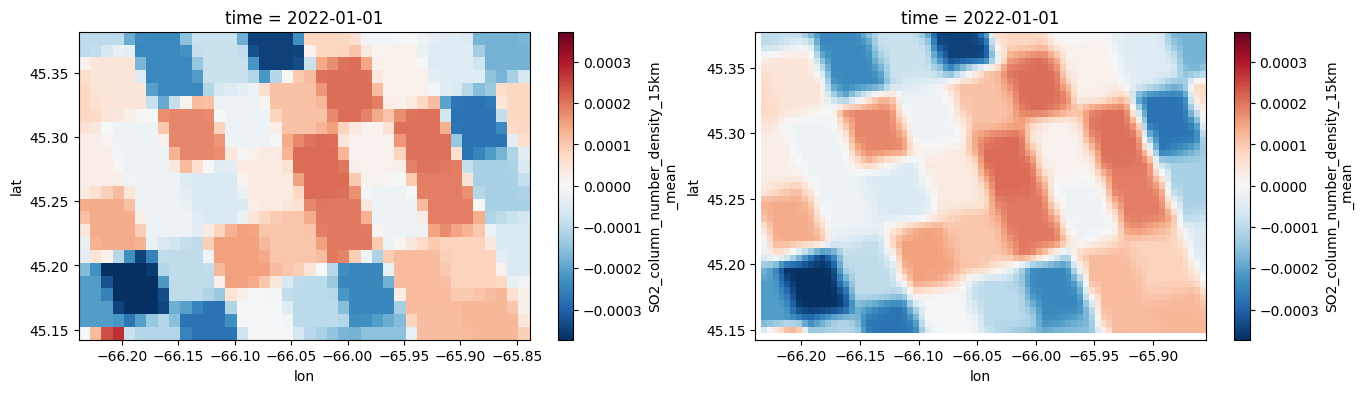

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 4))
tropomi_fusion_xr_correct.isel(time=31)['SO2_column_number_density_15km_mean'].plot(x='lon', y='lat', ax=axes[0])
tropomi_fusion_xr_interp.isel(time=31)['SO2_column_number_density_15km_mean'].plot(x='lon', y='lat', ax=axes[1])

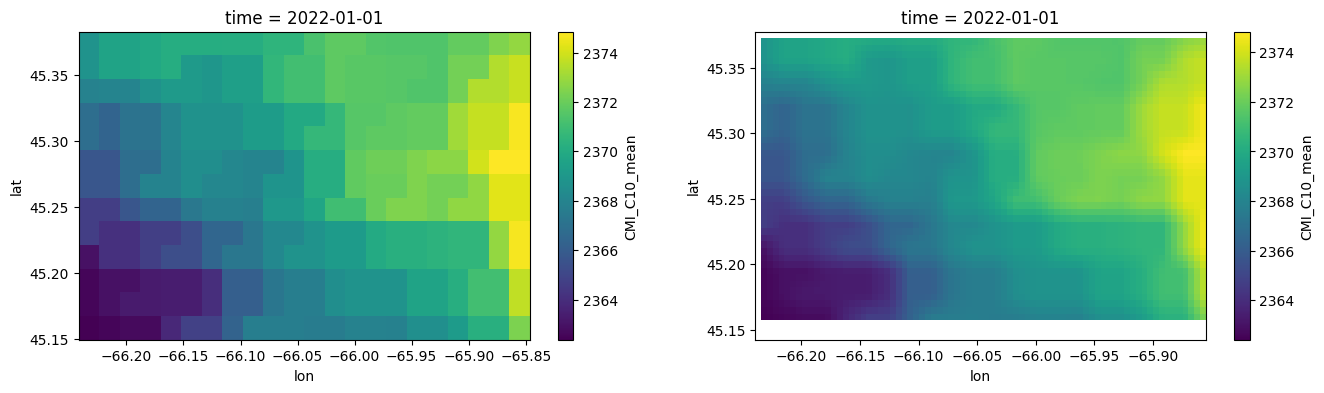

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 4))
goes_16_bands_fusion_xr_correct.isel(time=31)['CMI_C10_mean'].plot(x='lon', y='lat', ax=axes[0])
goes_16_bands_fusion_xr_interp.isel(time=31)['CMI_C10_mean'].plot(x='lon', y='lat', ax=axes[1])

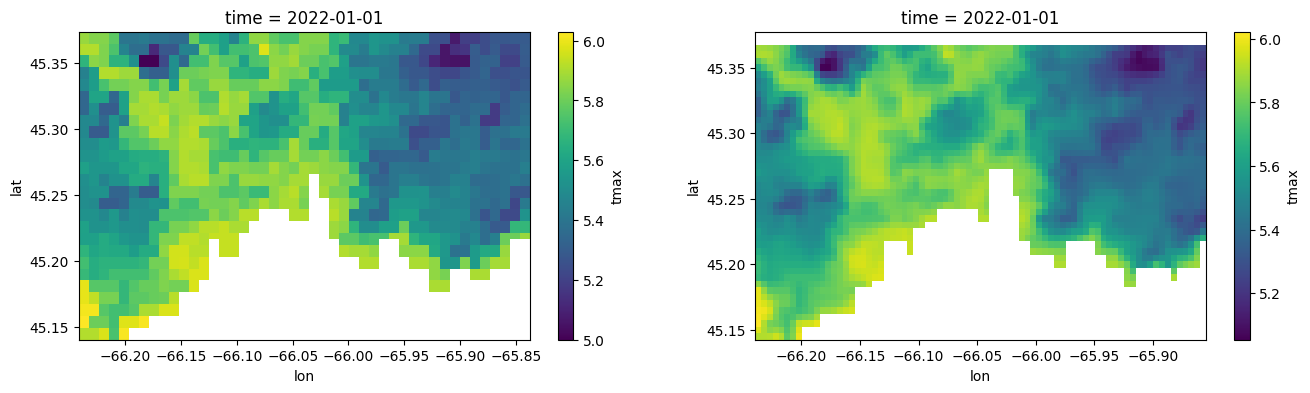

In [ ]:
####  Fill missing!

fig, axes = plt.subplots(ncols=2, figsize=(16, 4))
daymet_fusion_xr_correct.isel(time=31)['tmax'].plot(x='lon', y='lat', ax=axes[0])
daymet_fusion_xr_interp.isel(time=31)['tmax'].plot(x='lon', y='lat', ax=axes[1])

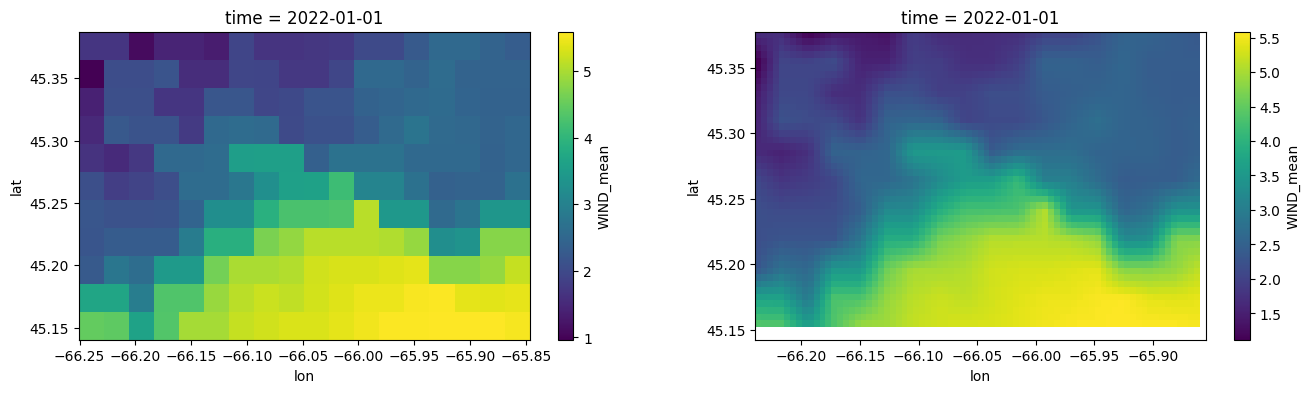

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 4))
rtma_fusion_xr_correct.isel(time=31)['WIND_mean'].plot(x='lon', y='lat', ax=axes[0])
rtma_fusion_xr_interp.isel(time=31)['WIND_mean'].plot(x='lon', y='lat', ax=axes[1])

In [ ]:
##  tesellated grid - 500 m
grid = gpd.read_file(f'/content/drive/MyDrive/reference_grids.shp')
grid = grid.set_crs(epsg=4326)

In [ ]:
## locate the main folder path
geotiff_folder = f"/content/drive/MyDrive/Rasters/"

# digital elevation  (30 m)
dem = rioxr.open_rasterio(geotiff_folder + "SJ_DEM.tif")
# building height  (100 m)
built_height = rioxr.open_rasterio(geotiff_folder + "SJ_built_height.tif")
# population density  (100 m)
pop_density = rioxr.open_rasterio(geotiff_folder + "SJ_pop_density-2020.tif")
# land cover (500 m)
land_cover = rioxr.open_rasterio(geotiff_folder + "SJ Modis_LandCover-2022.tif")

In [ ]:
# digital elevation  (30 m)
dem_extract_mean = eet.exact_extract(dem, grid, 'mean')
dem_extract_std = eet.exact_extract(dem, grid, 'stdev')
# building height  (100 m)
built_height_extract_mean = eet.exact_extract(built_height, grid, 'mean')
built_height_extract_std = eet.exact_extract(built_height, grid, 'stdev')
# population density  (100 m)
pop_density_extract_mean = eet.exact_extract(pop_density, grid, 'mean')
pop_density_extract_std = eet.exact_extract(pop_density, grid, 'stdev')
# land cover (500 m)
land_cover_frac = eet.exact_extract(land_cover, grid, 'frac')
land_cover_unique_values = eet.exact_extract(land_cover, grid, 'unique')

In [ ]:
dem_extract_mean_list = [dem_extract_mean[n]['properties']['mean'] for n in range(grid.shape[0])]
dem_extract_std_list = [dem_extract_std[n]['properties']['stdev'] for n in range(grid.shape[0])]
built_height_extract_mean_list = [built_height_extract_mean[n]['properties']['mean'] for n in range(grid.shape[0])]
built_height_extract_std_list = [built_height_extract_std[n]['properties']['stdev'] for n in range(grid.shape[0])]
pop_density_extract_mean_list = [pop_density_extract_mean[n]['properties']['mean'] for n in range(grid.shape[0])]
pop_density_extract_std_list = [pop_density_extract_std[n]['properties']['stdev'] for n in range(grid.shape[0])]

In [ ]:
land_cover_list = []

for n in range(grid.shape[0]):
    for m in range(len(land_cover_frac[n]['properties']['frac'])):
        grid_id = grid['id'].iloc[n]
        class_val = int(land_cover_unique_values[n]['properties']['unique'][m])
        class_frac = land_cover_frac[n]['properties']['frac'][m]
        out_land_cover = pd.DataFrame({'id': grid_id, 'land_cover_class': class_val, 'land_cover_frac': class_frac}, index=[0])
        land_cover_list.append(out_land_cover)

land_cover_df = pd.concat(land_cover_list).reset_index(drop=True)
land_cover_df = pd.pivot_table(land_cover_df, index=['id'], columns=['land_cover_class'], values=['land_cover_frac']).reset_index()
land_cover_df.columns = ['id', 
                         'water', 
                         'evergreen_needleleaf_vegetation', 
                         'evergreen_broadleaf_vegetation', 
                         'deciduous_needleleaf_vegetation', 
                         'deciduous_broadleaf_vegetation', 
                         'grass', 
                         'urban']
land_cover_df = land_cover_df.fillna(0)

In [ ]:
grid['dem_mean'] = pd.Series(dem_extract_mean_list)
grid['dem_std'] = pd.Series(dem_extract_std_list)
grid['bh_mean'] = pd.Series(built_height_extract_mean_list)
grid['bh_std'] = pd.Series(built_height_extract_std_list)
grid['pop_den_mean'] = pd.Series(pop_density_extract_mean_list)
grid['pop_den_std'] = pd.Series(pop_density_extract_std_list)
grid = grid.merge(land_cover_df, on=['id'], how='left')

In [ ]:
land_cover_unique_values = eet.exact_extract(land_cover, grid, 'unique')
land_cover_unique_values[0:10]

[{'type': 'Feature', 'properties': {'unique': array([0., 4.])}},
 {'type': 'Feature', 'properties': {'unique': array([0., 4.])}},
 {'type': 'Feature', 'properties': {'unique': array([0.])}},
 {'type': 'Feature', 'properties': {'unique': array([1., 0.])}},
 {'type': 'Feature', 'properties': {'unique': array([0., 1.])}},
 {'type': 'Feature', 'properties': {'unique': array([1.])}},
 {'type': 'Feature', 'properties': {'unique': array([1.])}},
 {'type': 'Feature', 'properties': {'unique': array([4., 1.])}},
 {'type': 'Feature', 'properties': {'unique': array([1., 4.])}},
 {'type': 'Feature', 'properties': {'unique': array([4.])}}]

In [ ]:
land_cover_values = eet.exact_extract(land_cover, grid, 'values')
land_cover_values[0:10]

[{'type': 'Feature', 'properties': {'values': array([4., 4., 4., 0.])}},
 {'type': 'Feature', 'properties': {'values': array([4., 0., 0., 0.])}},
 {'type': 'Feature', 'properties': {'values': array([0., 0., 0., 0.])}},
 {'type': 'Feature', 'properties': {'values': array([0., 0., 1., 0.])}},
 {'type': 'Feature', 'properties': {'values': array([1., 0., 1., 1.])}},
 {'type': 'Feature', 'properties': {'values': array([1., 1., 1., 1.])}},
 {'type': 'Feature', 'properties': {'values': array([1., 1., 1., 1.])}},
 {'type': 'Feature',
  'properties': {'values': array([1., 1., 1., 1., 4., 1.])}},
 {'type': 'Feature', 'properties': {'values': array([4., 1., 4., 4.])}},
 {'type': 'Feature', 'properties': {'values': array([4., 4., 4., 4.])}}]

In [ ]:
land_cover_frac = eet.exact_extract(land_cover, grid, 'frac')
land_cover_frac[0:10]

[{'type': 'Feature', 'properties': {'frac': array([0.15436269, 0.8456372 ])}},
 {'type': 'Feature', 'properties': {'frac': array([0.71922719, 0.28077284])}},
 {'type': 'Feature', 'properties': {'frac': array([1.])}},
 {'type': 'Feature', 'properties': {'frac': array([0.26967353, 0.73032647])}},
 {'type': 'Feature', 'properties': {'frac': array([0.16752838, 0.83247155])}},
 {'type': 'Feature', 'properties': {'frac': array([1.])}},
 {'type': 'Feature', 'properties': {'frac': array([1.])}},
 {'type': 'Feature', 'properties': {'frac': array([0.04481618, 0.95518386])}},
 {'type': 'Feature', 'properties': {'frac': array([0.43424749, 0.56575257])}},
 {'type': 'Feature', 'properties': {'frac': array([1.])}}]

In [ ]:
## locate the main folder path
vector_folder = f"./src/"

In [ ]:
# read all vector features
bus_route = gpd.read_file(vector_folder + "SJ Open Data/_shapefiles/Bus_Routes.shp")
bus_stop = gpd.read_file(vector_folder + "SJ Open Data/_shapefiles/Bus_Stops.shp")
rail_road = gpd.read_file(vector_folder + "SJ Open Data/_shapefiles/Railroads.shp")
trail = gpd.read_file(vector_folder + "SJ Open Data/_shapefiles/Trails.shp")

sj_zone = gpd.read_file(vector_folder + "SJ Open Data/_shapefiles/Zoning.shp")

bus_route = bus_route.to_crs(epsg=4326)
bus_stop = bus_stop.to_crs(epsg=4326)
rail_road = rail_road.to_crs(epsg=4326)
trail = trail.to_crs(epsg=4326)

sj_zone = sj_zone.to_crs(epsg=4326)

In [ ]:
#  find aggregated features
bus_stop_within = gpd.sjoin(bus_stop, grid, how="inner", predicate='within').groupby(["id"]).agg({"stop_id": "count"}).reset_index()
bus_stop_within.columns = ["id", "bus_stop_count"]

bus_route_intersect = gpd.sjoin(bus_route, grid, how="inner", predicate='intersects').groupby(["id"]).agg({"Route": "count", "Shape__Len": "sum"}).reset_index()
bus_route_intersect.columns = ["id", "bus_route_count", "bus_route_length"]

rail_road_intersect = gpd.overlay(grid, rail_road, how="intersection", keep_geom_type=False)
rail_road_intersect['length'] = rail_road_intersect.geometry.length
rail_road_intersect = rail_road_intersect.groupby(["id"]).agg({"GlobalID": "count", "length": "sum"}).reset_index()
rail_road_intersect.columns = ["id", 'railroad_count', 'railroad_length']

trail_intersect = gpd.overlay(grid, trail, how="intersection", keep_geom_type=False)
trail_intersect['length'] = trail_intersect.geometry.length
trail_intersect = trail_intersect.groupby(["id"]).agg({"GlobalID": "count", "length": "sum"}).reset_index()
trail_intersect.columns = ["id", 'trail_count', 'trail_length']

sj_zone_ratio = gpd.sjoin(sj_zone , grid, how="inner", predicate='intersects').groupby(["id","ZoningGrou"]).agg({"Shape__Are": "sum"}).reset_index()
sj_zone_ratio = sj_zone_ratio.pivot_table(index="id", values="Shape__Are", columns="ZoningGrou").reset_index()
sj_zone_ratio.iloc[:,1:] = sj_zone_ratio.iloc[:,1:].apply(lambda x: x / x.sum(), axis = 1)

In [ ]:
# OpensTreetMap features
osm_highways = pd.read_excel(vector_folder + "OSM_highways.xlsx")
osm_highways['geometry'] = gpd.GeoSeries(osm_highways['geometry'].apply(lambda x: shapely.wkt.loads(x)))
osm_highways_shp = gpd.GeoDataFrame(osm_highways[['osmid', 'geometry', 'highway', 'lanes', 'maxspeed']], geometry="geometry")
osm_highways_shp = osm_highways_shp.set_crs(epsg=4326)
osm_highways_shp['lanes'] = osm_highways_shp['lanes'].fillna(0)

In [ ]:
# OpensTreetMap aggregated features
osm_highways_intersect = gpd.overlay(grid, osm_highways_shp, how="intersection", keep_geom_type=False)
osm_highways_intersect['length'] = osm_highways_intersect.geometry.length
osm_highways_intersect = osm_highways_intersect.groupby(["id"]).agg({"length": "sum", "lanes": "sum", "maxspeed": np.nanmax}).reset_index()
osm_highways_intersect.columns = ['id','osm_road_length','osm_lanes',"maxspeed"]

In [ ]:
grid = grid.merge(bus_stop_within, on=["id"], how="left") \
            .merge(bus_route_intersect, on=["id"], how="left") \
            .merge(rail_road_intersect, on=["id"], how="left") \
            .merge(trail_intersect, on=["id"], how="left") \
            .merge(sj_zone_ratio, on=["id"], how="left") \
            .merge(osm_highways_intersect, on=["id"], how="left")

grid.iloc[:,2:-1] = grid.iloc[:,2:-1].fillna(0)